In [2]:
import torch
from diffusers import StableDiffusion3Pipeline
from attention_map_diffusers import (
    attn_maps,
    init_pipeline,
    save_attention_maps
)

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")

pipe = init_pipeline(pipe)

prompts = [
    "A capybara holding a sign that reads Hello World.",
]

images = pipe(
    prompts,
    negative_prompt="hands",
    num_inference_steps=15,
    guidance_scale=4.5,
).images

for batch, image in enumerate(images):
    image.save(f'{batch}-sd3-5.png')

save_attention_maps(attn_maps, pipe.tokenizer, prompts, base_dir='attn_maps-sd3-5', unconditional=True)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

NameError: name 'total_tokens' is not defined

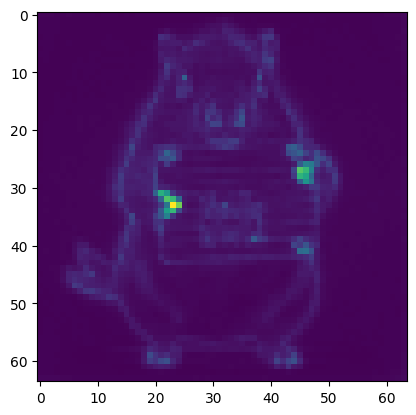

In [7]:
import os
import torch.nn.functional as F

token_ids =pipe.tokenizer(["hands"])['input_ids']
# token_ids = pipe.tokenizer(prompts)['input_ids']
token_ids = token_ids if token_ids and isinstance(token_ids[0], list) else [token_ids]
total_tokens = [pipe.tokenizer.convert_ids_to_tokens(token_id) for token_id in token_ids]

total_attn_map = list(list(attn_maps.values())[0].values())[0].sum(1)
total_attn_map = total_attn_map.chunk(2)[0]  # (batch, height, width, attn_dim)
total_attn_map = total_attn_map.permute(0, 3, 1, 2)
total_attn_map = torch.zeros_like(total_attn_map)
total_attn_map_shape = total_attn_map.shape[-2:]

layers = list(attn_maps.values())[10]
maps = []
for layer, attn_map in layers.items():
    layer_dir = os.path.join(f'{layer}')
    
    attn_map = attn_map.sum(1).squeeze(1).permute(0, 3, 1, 2)
    attn_map = attn_map.chunk(2)[0]
    
    resized_attn_map = F.interpolate(attn_map, size=total_attn_map_shape, mode='bilinear', align_corners=False)
    total_attn_map += resized_attn_map
    
    for batch, (tokens, attn) in enumerate(zip(total_tokens, attn_map)):
        batch_dir = os.path.join(layer_dir, f'batch-{batch}')
        maps.append(attn_map)

import pylab
pylab.imshow(resized_attn_map.detach().float().cpu().numpy().mean(0)[1:2].mean(0))

In [5]:
{i:j for i, j in enumerate(total_tokens[0])}

{0: '<|startoftext|>',
 1: 'a</w>',
 2: 'cap',
 3: 'y',
 4: 'bara</w>',
 5: 'holding</w>',
 6: 'a</w>',
 7: 'sign</w>',
 8: 'that</w>',
 9: 'reads</w>',
 10: 'hello</w>',
 11: 'world</w>',
 12: '.</w>',
 13: '<|endoftext|>'}